#Project: AI for the Industry 4.0

## Description

A company producing fiber optic sensors decided to implement the concept
of Industry 4.0 in one of their production processes. They are going to
implement the AI techniques to automate verification of produced sensors.
Currently, after the production of the sensor, its characteristics should be
verified each time in three reference substances in order to configure:

*   Air
*   Water
*   Isopropanol

After the procedure in the laboratory they collected three spectroscopic
signals. Unfortunately, such procedures are extremely time consuming and
require large human resources. Therefore they are planning to implement AI
algorithms in order to predict characteristics (or any other parameters – you
can propose something) of a working sensor in water and isopropanol based
on measured characteristics in air. It will enable to reduce validation process
only to measurements in the air, but other characteristics will be collected
based on the proposed model.

Dataset of manufactured sensors are collected in the google drive:
https://drive.google.com/drive/folders/1ha7P4Mwp6_XYnUHs20460CbBC4zwNvf9?usp=share_link

It's a collection of measurements based on 10 sensors . Each sensor was
measured three times that you can find in three separated files (e.g.
sensor01_air.txt, sensor01_water.txt, sensor01_izopropanol.txt). Each file
contains two-dimensional signal (signal wavelength, signal amplitude) as you
can observe in figure 1.

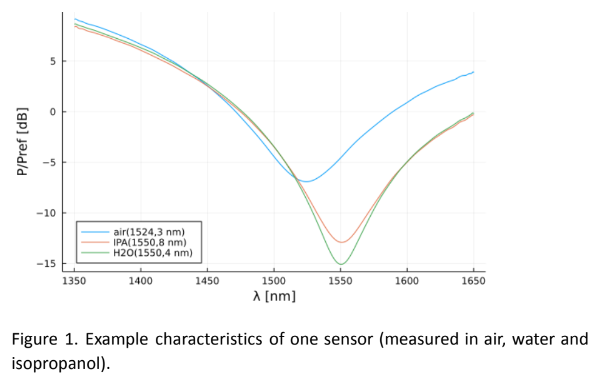

Based on this characteristics you can use any data mining and machine
learning techniques. Of course you can use any mechanisms e.g. data
enrichment, feature extraction, signal analysis, etc. The ultimate goal of this
task is facing the real problem and design and plan AI implementation plan
as follows:

1. Prepare a demonstration of your concept of this project in order to
convince the client of your idea (you can use any tools).
2. Implement your solution using the Google Colab tool.
3. Prepare publication of your preliminary results.
4. Share all materials from points 1, 2 and 3 in your personal GitHub or
GitLab account and send us the link.

# Concept

* Problem seems to be non-linear regression problem so algorithms taken under consideration are e.g. Polynomial LR, SVR (with poly kernel), KNregressor
* As bonus ensemble methods to be used
* Standard data check (data types, missing values, outliers)
* For the first step take mean of all 10 sensors measurements to regression model as target value. Further analysis can be done with all 10 sensors results.



## Initial thoughts

* Checking the fiber optic characteristic wave length starts at 0,8nm. This data seems to be only part of whole charateristic. Somewhere between 2nd and 3rd window ('water peak' area)

http://fowiki.com/b/understand-fiber-attenuation/ 

* The lower y value, the bigger attenuation which gives signal loss.


# Load libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, sys
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# url_folder='https://github.com/mrMichalR/AI_for_industry/tree/main/Dataset/sesion_01_20'

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/Dataset

Mounted at /content/drive
/content/drive/MyDrive/Dataset


# Data preparation & analysis

## Load files

In [4]:
air_list = []
iso_list = []
water_list = []
files_list=[]

root = os.getcwd()
path = os.path.join(root, ".txt")


for path, subdirs, files in os.walk(root):
  for name in files:
    temp_file = os.path.join(path, name)
    # print(temp_file)
    # files_list.append(temp_file)
    if name.endswith('air.txt'):
      # print(name)
      air_list.append(temp_file)
      # air_list.append(pd.read_csv(temp_file, sep=',', header=None))
    if name.endswith('izopropanol.txt'):
      # print(name)
      iso_list.append(temp_file)
      # iso_list.append(pd.read_csv(temp_file, sep=',', header=None))
    if name.endswith('water.txt'):
      # print(name)
      water_list.append(temp_file)
      # water_list.append(pd.read_csv(temp_file, sep=',', header=None))

# print(files_list)

# print('Air list:', air_list)
# print('isopropanol list:', iso_list)
# print('Water list:', water_list)

air_list_sort = np.sort(air_list)
iso_list_sort = np.sort(iso_list)
water_list_sort = np.sort(water_list)

print('Sorted air list: \n', air_list_sort)
print('Sorted isopropanol list: \n', iso_list_sort)
print('Sorted water list: \n', water_list_sort)

Sorted air list: 
 ['/content/drive/MyDrive/Dataset/sesion_01_20/sensor01_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_02_20/sensor02_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_03_20/sensor03_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_04_20/sensor04_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_05_20/sensor05_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_06_20/sensor06_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_07_20/sensor07_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_08_20/sensor08_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_09_20/sensor09_air.txt'
 '/content/drive/MyDrive/Dataset/sesion_10_20/sensor10_air.txt']
Sorted isopropanol list: 
 ['/content/drive/MyDrive/Dataset/sesion_01_20/sensor01_izopropanol.txt'
 '/content/drive/MyDrive/Dataset/sesion_02_20/sensor02_izopropanol.txt'
 '/content/drive/MyDrive/Dataset/sesion_03_20/sensor03_izopropanol.txt'
 '/content/drive/MyDrive/Dataset/sesion_04_20/sensor04_izopropanol.txt'
 '/content/drive/MyDrive/

In [5]:
def create_df (feature_name_list):
  new_df_list=[]
  for elem in feature_name_list:
    # print(elem)
    new_df = pd.read_csv(elem, sep=',', header=None)
    new_df_list.append(new_df)
  df = pd.concat(new_df_list, axis=1, ignore_index=False)
  return df

In [6]:
air_reduced = create_df(air_list_sort).loc[:,~create_df(air_list_sort).T.duplicated(keep='first')]
iso_reduced = create_df(iso_list_sort).loc[:,~create_df(iso_list_sort).T.duplicated(keep='first')]
water_reduced = create_df(water_list_sort).loc[:,~create_df(water_list_sort).T.duplicated(keep='first')]

In [7]:
air_reduced.head(10)

,0,1,1,1,1,1,1,1,1,1,1
0,0.000001,9.1792,9.7793,7.8831,8.0963,9.4439,9.4554,8.8064,9.9081,8.6910,9.2124
1,0.000001,9.2003,9.8643,8.0971,8.1872,9.6645,9.6052,8.9714,10.0010,8.7223,9.2734
2,0.000001,9.1968,9.8031,7.9478,8.2061,9.5697,9.6264,8.9747,9.9366,8.7796,9.1703
3,0.000001,9.1028,9.7320,7.9979,8.1094,9.6378,9.5136,8.8461,9.8126,8.6753,9.2478
4,0.000001,9.0601,9.6895,7.9220,7.9691,9.4933,9.4042,8.8265,9.8773,8.6667,9.0771
5,0.000001,9.1118,9.6751,7.9398,7.9983,9.4646,9.3976,8.7838,9.7859,8.6335,9.2124
6,0.000001,9.1082,9.8390,7.9327,8.1034,9.5433,9.4297,8.8814,9.8417,8.7144,9.2134
7,0.000001,9.1401,9.7645,7.9529,8.0671,9.5420,9.5126,8.8718,9.8616,8.7337,9.2372
8,0.000001,9.2533,9.8178,8.0276,8.2137,9.5720,9.5449,9.0086,9.9351,8.7412,9.3312
9,0.000001,9.1403,9.8695,7.9734,7.9368,9.5126,9.4615,8.8919,9.8413,8.6552,9.1411


In [8]:
iso_reduced.head(10)

,0,1,1,1,1,1,1,1,1,1,1
0,0.000001,8.5551,9.2544,7.3432,7.4954,8.9739,8.8085,8.2594,9.3247,8.1031,8.7030
1,0.000001,8.6750,9.3012,7.4798,7.6049,9.0295,9.0038,8.3246,9.4571,8.2641,8.7322
2,0.000001,8.7116,9.2512,7.4810,7.5770,8.9789,8.9254,8.2975,9.3304,8.2080,8.6748
3,0.000001,8.7157,9.2734,7.4719,7.4928,8.9369,8.8786,8.3300,9.3175,8.1822,8.5932
4,0.000001,8.6792,9.1999,7.3330,7.4703,8.9419,8.8290,8.2628,9.2751,8.0794,8.5665
5,0.000001,8.6312,9.1273,7.3773,7.4842,8.8595,8.8734,8.2826,9.3226,8.0380,8.5684
6,0.000001,8.5790,9.2143,7.4270,7.5368,8.9942,8.9079,8.2182,9.3161,8.0850,8.5508
7,0.000001,8.7378,9.2502,7.3881,7.4911,8.9808,8.8774,8.2864,9.2406,8.2056,8.6063
8,0.000001,8.7874,9.3900,7.4502,7.6697,9.0207,8.9629,8.3294,9.5515,8.2634,8.7008
9,0.000001,8.5679,9.2200,7.3618,7.5023,8.9267,8.8763,8.2688,9.2987,8.1004,8.5083


In [9]:
water_reduced.head(10)

,0,1,1,1,1,1,1,1,1,1,1
0,0.000001,8.3570,9.0607,7.2354,7.3714,8.6370,8.7331,8.1180,9.1633,7.8706,8.3966
1,0.000001,8.4287,9.1238,7.3520,7.3794,8.8197,8.7934,8.2177,9.2473,8.0872,8.5327
2,0.000001,8.4422,9.1159,7.3746,7.3017,8.7279,8.7887,8.0696,9.2127,8.0130,8.4086
3,0.000001,8.4144,9.0431,7.2810,7.2528,8.7620,8.7277,8.1302,9.1313,7.9647,8.4676
4,0.000001,8.4034,8.9860,7.0982,7.2032,8.7683,8.7171,7.9694,9.0760,7.9518,8.3277
5,0.000001,8.3351,9.0339,7.1982,7.2758,8.7061,8.7221,8.0236,9.1281,7.8739,8.4390
6,0.000001,8.2999,9.0202,7.1621,7.2670,8.7494,8.6598,8.1107,9.1439,7.9986,8.4466
7,0.000001,8.4229,9.1341,7.2401,7.3706,8.7382,8.7003,8.1325,9.2849,7.9623,8.4476
8,0.000001,8.5613,9.2108,7.3294,7.3727,8.7636,8.8810,8.2029,9.2166,7.9913,8.4513
9,0.000001,8.4437,8.9912,7.2356,7.2238,8.7546,8.7577,8.0463,9.0608,7.8490,8.3854


In [10]:
air_reduced.columns

Int64Index([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype='int64')

## Rename columns

In [11]:
new_names=[]
for cols in range(len(air_reduced.columns)):
  new='sensor_' + str(cols) # +'_' + variable_name.split('_',1) #do poprawy
  print(new)
  new_names.append(new)
new_names[0]='wave_length'

# Assining new names to columns
air_reduced.columns = new_names
iso_reduced.columns = new_names
water_reduced.columns = new_names
# new_names=[]

sensor_0
sensor_1
sensor_2
sensor_3
sensor_4
sensor_5
sensor_6
sensor_7
sensor_8
sensor_9
sensor_10


In [12]:
air = air_reduced
iso = iso_reduced
water = water_reduced

In [13]:
set_option('precision',12)
air

,wave_length,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,0.0000013500,9.1792,9.7793,7.8831,8.0963,9.4439,9.4554,8.8064,9.9081,8.6910,9.2124
1,0.0000013501,9.2003,9.8643,8.0971,8.1872,9.6645,9.6052,8.9714,10.0010,8.7223,9.2734
2,0.0000013502,9.1968,9.8031,7.9478,8.2061,9.5697,9.6264,8.9747,9.9366,8.7796,9.1703
3,0.0000013503,9.1028,9.7320,7.9979,8.1094,9.6378,9.5136,8.8461,9.8126,8.6753,9.2478
4,0.0000013504,9.0601,9.6895,7.9220,7.9691,9.4933,9.4042,8.8265,9.8773,8.6667,9.0771
...,...,...,...,...,...,...,...,...,...,...,...
2996,0.0000016496,3.8310,3.5505,2.3074,1.5783,2.8330,2.4787,2.9408,3.7791,2.7312,3.2784
2997,0.0000016497,3.8613,3.8237,2.3935,1.7888,2.9789,2.9384,3.2277,3.6568,2.7287,3.4213
2998,0.0000016498,3.8361,3.6708,2.2550,1.3259,2.7841,2.4859,2.8527,3.7064,2.5725,3.3112
2999,0.0000016499,3.9466,3.8785,2.4935,1.6945,2.9465,2.9317,3.3101,3.7920,2.7335,3.4500


## Decriptive analysis

In [14]:
air.head()

,wave_length,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,0.0000013500,9.1792,9.7793,7.8831,8.0963,9.4439,9.4554,8.8064,9.9081,8.6910,9.2124
1,0.0000013501,9.2003,9.8643,8.0971,8.1872,9.6645,9.6052,8.9714,10.0010,8.7223,9.2734
2,0.0000013502,9.1968,9.8031,7.9478,8.2061,9.5697,9.6264,8.9747,9.9366,8.7796,9.1703
3,0.0000013503,9.1028,9.7320,7.9979,8.1094,9.6378,9.5136,8.8461,9.8126,8.6753,9.2478
4,0.0000013504,9.0601,9.6895,7.9220,7.9691,9.4933,9.4042,8.8265,9.8773,8.6667,9.0771


In [15]:
for elem in [air,iso,water]:
  print(elem.info(),2*'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   wave_length  3001 non-null   float64
 1   sensor_1     3001 non-null   float64
 2   sensor_2     3001 non-null   float64
 3   sensor_3     3001 non-null   float64
 4   sensor_4     3001 non-null   float64
 5   sensor_5     3001 non-null   float64
 6   sensor_6     3001 non-null   float64
 7   sensor_7     3001 non-null   float64
 8   sensor_8     3001 non-null   float64
 9   sensor_9     3001 non-null   float64
 10  sensor_10    3001 non-null   float64
dtypes: float64(11)
memory usage: 258.0 KB
None 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   wave_length  3001 non-null   float64
 1   sensor_1     3001 non-null   float64
 2   sensor_2     300

In [16]:
for elem in [air,iso,water]:
  print(elem.isnull().any(),2*'\n')

wave_length    False
sensor_1       False
sensor_2       False
sensor_3       False
sensor_4       False
sensor_5       False
sensor_6       False
sensor_7       False
sensor_8       False
sensor_9       False
sensor_10      False
dtype: bool 


wave_length    False
sensor_1       False
sensor_2       False
sensor_3       False
sensor_4       False
sensor_5       False
sensor_6       False
sensor_7       False
sensor_8       False
sensor_9       False
sensor_10      False
dtype: bool 


wave_length    False
sensor_1       False
sensor_2       False
sensor_3       False
sensor_4       False
sensor_5       False
sensor_6       False
sensor_7       False
sensor_8       False
sensor_9       False
sensor_10      False
dtype: bool 




In [17]:
set_option('precision', 2)
for elem in [air,iso,water]:
  print(elem.describe(),2*'\n')

       wave_length  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
count     3.00e+03   3001.00   3001.00   3001.00   3001.00   3001.00   
mean      1.50e-06      1.19      1.44     -0.25     -0.26      1.26   
std       8.66e-08      4.72      4.93      4.82      4.98      4.88   
min       1.35e-06     -7.15     -7.12     -8.73     -8.80     -6.91   
25%       1.42e-06     -2.63     -2.60     -4.17     -4.38     -2.80   
50%       1.50e-06      1.62      1.72      0.13     -0.13      1.30   
75%       1.57e-06      4.89      5.55      3.58      4.04      5.51   
max       1.65e-06      9.25      9.87      8.10      8.26      9.66   

       sensor_6  sensor_7  sensor_8  sensor_9  sensor_10  
count   3001.00   3001.00   3001.00   3001.00    3001.00  
mean       1.10      0.63      1.54      0.33       1.02  
std        4.96      4.76      4.89      4.90       4.80  
min       -7.28     -7.56     -6.89     -8.22      -7.36  
25%       -3.01     -3.26     -2.48     -3.65      -2.93

In [18]:
# # correlation
# set_option('precision', 2)
# print(air.corr(method='pearson'))

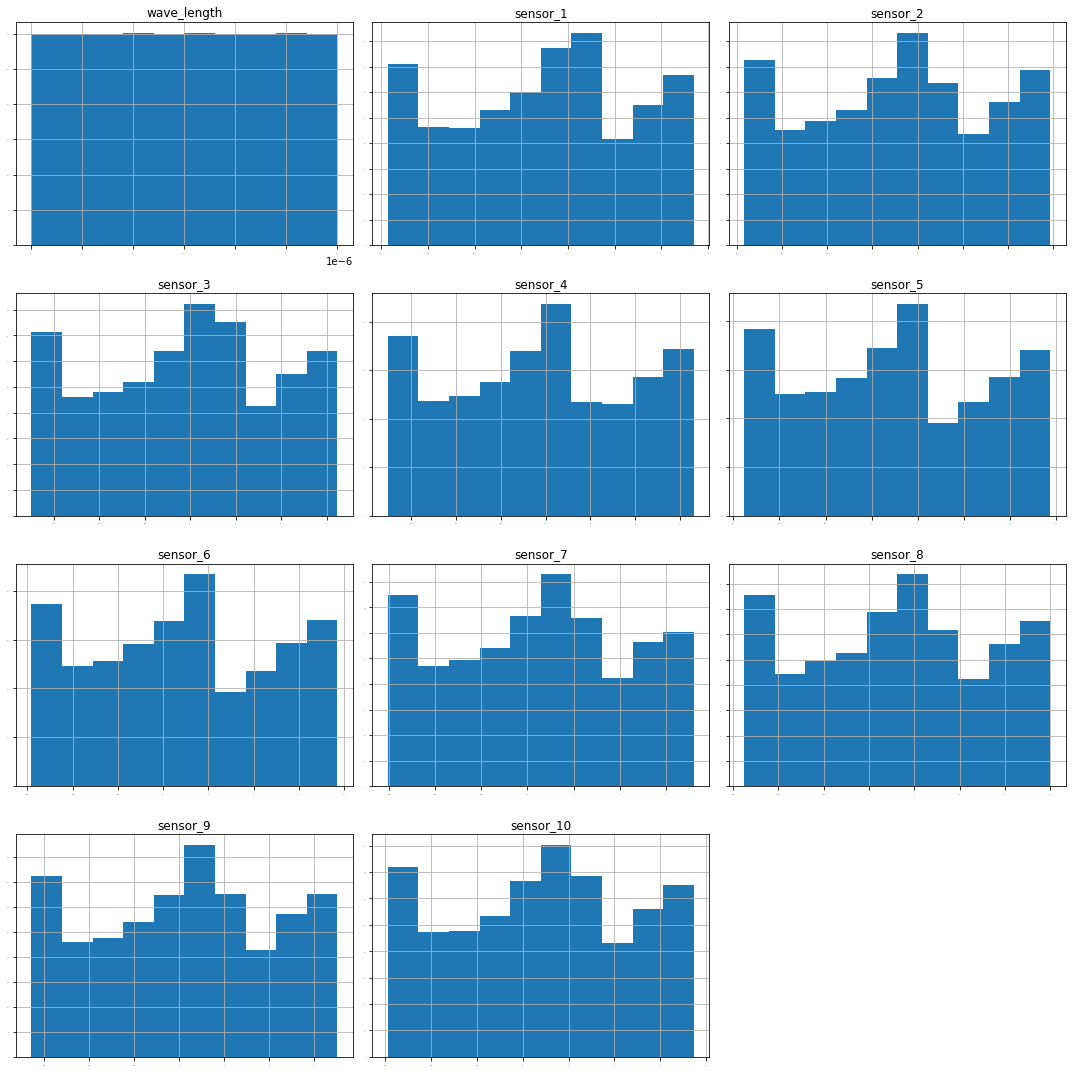

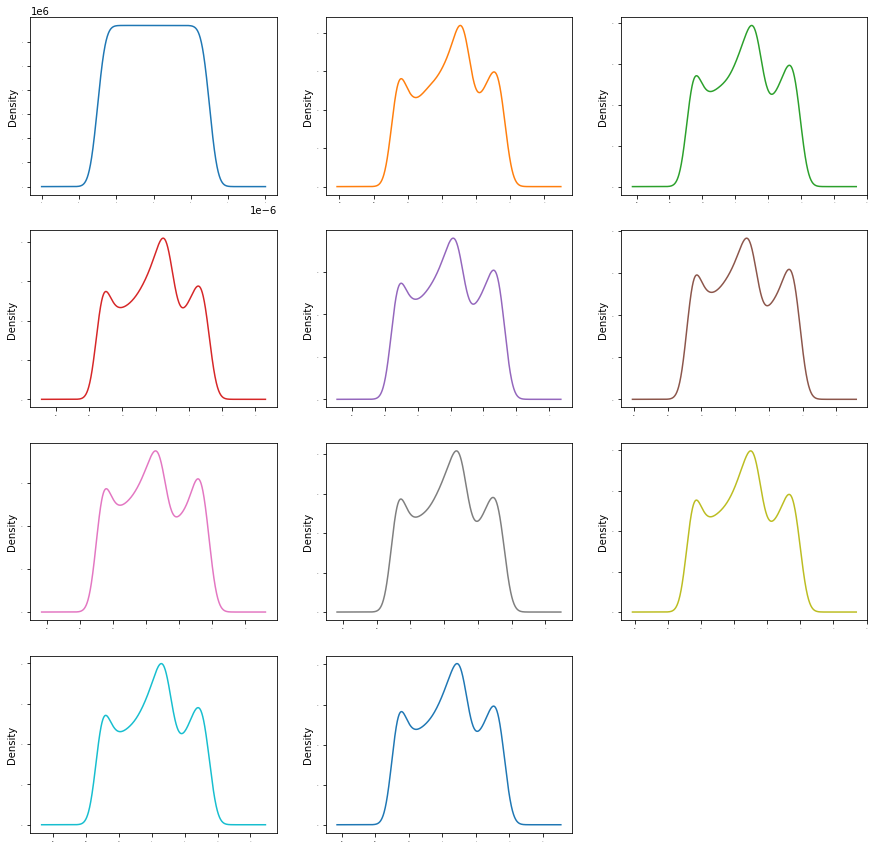

In [19]:
# histograms of each attribute to get a sense of the data distributions
air.hist(figsize=(15,15), sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.tight_layout()
plt.show()

# density
air.plot(kind='density', figsize=(15,15), subplots=True, layout=(4,3), sharex=False, legend=False, fontsize=1)
plt.show()

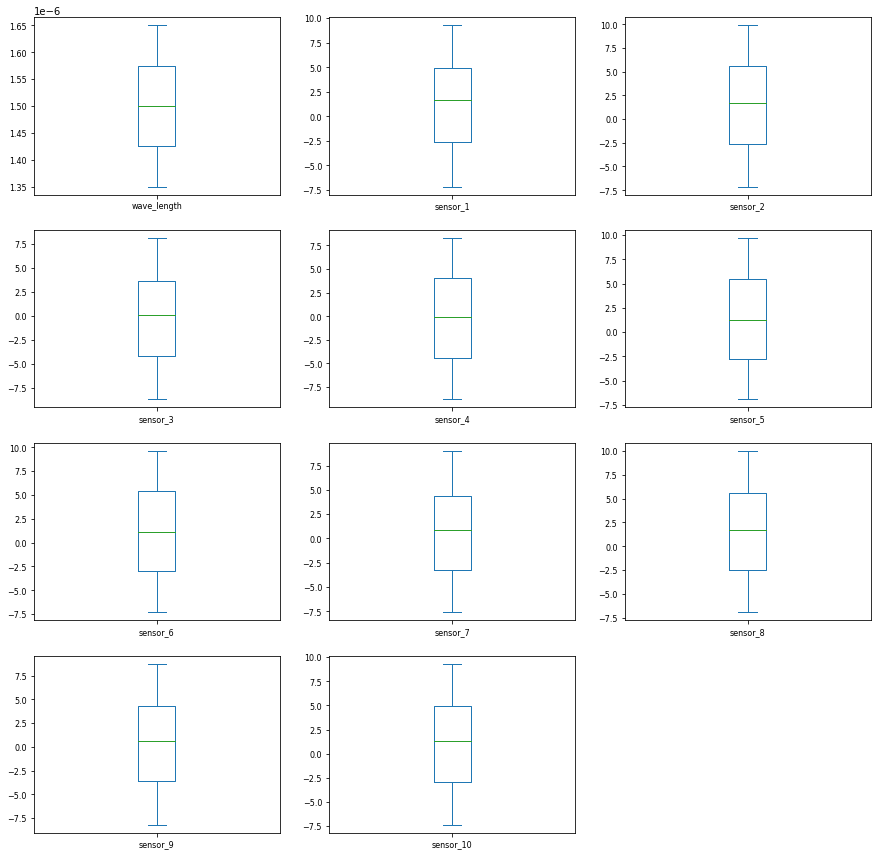

In [20]:
# box and whisker plots
air.plot(kind='box', figsize=(15,15), subplots=True, layout=(4,3), sharex=False, sharey=False, fontsize=8)
plt.show()

After data analysis decided, for start, to count/create mean value of all 10 sensors signal for each enviroment.

## Calculating mean value for signal amplitude

In [21]:
iso['mean_iso'] = iso.iloc[:, 1:11].mean(axis=1)
# iso[:,0,0]
print(iso, 3*'\n')

air['mean_air'] = air.iloc[:, 1:11].mean(axis=1)
print(air, 3*'\n')

water['mean_water'] = water.iloc[:, 1:11].mean(axis=1)
print(water, 3*'\n')

      wave_length  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  \
0        1.35e-06      8.56  9.25e+00      7.34      7.50      8.97      8.81   
1        1.35e-06      8.68  9.30e+00      7.48      7.60      9.03      9.00   
2        1.35e-06      8.71  9.25e+00      7.48      7.58      8.98      8.93   
3        1.35e-06      8.72  9.27e+00      7.47      7.49      8.94      8.88   
4        1.35e-06      8.68  9.20e+00      7.33      7.47      8.94      8.83   
...           ...       ...       ...       ...       ...       ...       ...   
2996     1.65e-06     -0.34 -3.94e-01     -1.75     -2.47     -1.44     -1.53   
2997     1.65e-06     -0.20 -2.16e-01     -1.42     -2.51     -1.31     -1.40   
2998     1.65e-06     -0.40 -2.97e-01     -1.57     -2.54     -1.40     -1.41   
2999     1.65e-06      0.03 -1.18e-01     -1.44     -2.21     -1.10     -1.13   
3000     1.65e-06     -0.22  1.78e-03     -1.21     -2.27     -1.16     -1.01   

      sensor_7  sensor_8  s

## Summary plot

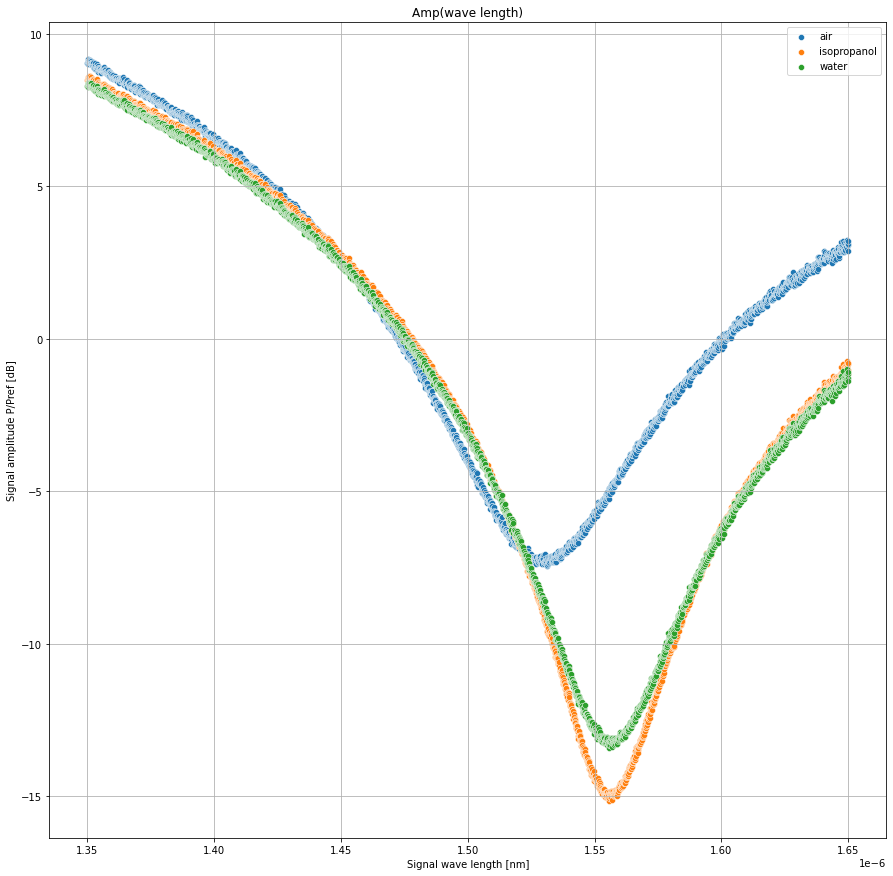

In [22]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Amp(wave length)")
sns.scatterplot(data=air, x='wave_length', y='mean_air', label='air')
sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol')
sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water')
plt.grid()
plt.legend()

## Summary

* no missing values
* no outliers
* uniform data type
* data distribution are similar
* density very similar
* signal amplitude e.g. -5dB for all 3 enviroments can be achieved for two wave lengths. So we need to track the wave length. 

## General dataframe

For demonstration purpose, creating final general dataframe for all 3 enviroments with mean amplitude values.

In [23]:
mean_results = pd.concat([air['wave_length'],air['mean_air'], iso['mean_iso'], water['mean_water']], axis=1)
set_option('precision',10)
mean_results

,wave_length,mean_air,mean_iso,mean_water
0,0.0000013500,9.04551,8.48207000,8.294310
1,0.0000013501,9.15867,8.58722000,8.398190
2,0.0000013502,9.12111,8.54358000,8.345490
3,0.0000013503,9.06753,8.51922000,8.317480
4,0.0000013504,8.99858,8.46371000,8.250110
...,...,...,...,...
2996,0.0000016496,2.93084,-1.09830500,-1.320583
2997,0.0000016497,3.08191,-1.02440500,-1.282892
2998,0.0000016498,2.88006,-1.14558900,-1.391228
2999,0.0000016499,3.11769,-0.82895060,-1.165640


# Model build for Water based on air

##  Dataset split for Water based on Air

In [24]:
# Split-out validation dataset\
df_water = mean_results.copy()
X_water_air = df_water.drop(['mean_iso'], axis=1) # zmienne niezależne (features)
y_water_air = df_water.pop('mean_water') # zmienna zależna (target)

X_train_water_air, X_test_water_air, y_train_water_air, y_test_water_air = train_test_split(X_water_air, y_water_air, test_size=0.20, random_state=42)

print("X_train_water_air dimension = ", X_train_water_air.shape)
print("X_test_water_air dimension = ", X_test_water_air.shape)
print("y_train_water_air dimension = ", y_train_water_air.shape)
print("y_train_water_air dimension = ", y_test_water_air.shape)
X_train_water_air.reset_index(inplace=True, drop=True)
X_test_water_air.reset_index(inplace=True, drop=True)
y_train_water_air.reset_index(inplace=True, drop=True)
y_test_water_air.reset_index(inplace=True, drop=True)

X_train_water_air dimension =  (2400, 3)
X_test_water_air dimension =  (601, 3)
y_train_water_air dimension =  (2400,)
y_train_water_air dimension =  (601,)


## Evaluate Algorithms: Baseline

In [25]:
# Test options and evaluation metric
# num_folds = 10
# seed = 42
# scoring = 'neg_mean_squared_error'

In [26]:
# Spot-Check Algorithms
models = []
models.append(('KNN', KNeighborsRegressor(n_neighbors=1)))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR(kernel='poly')))

Specified parameter n_neighbors=1 for KNN and kernel='poly' SVM. This is because of checking results on plot in below section 'Plot-check preditions on train'

In [27]:
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_water_air, y_train_water_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

KNN: -0.000700 (0.000071)
CART: -0.000195 (0.000029)
SVR: -3.308925 (0.140099)


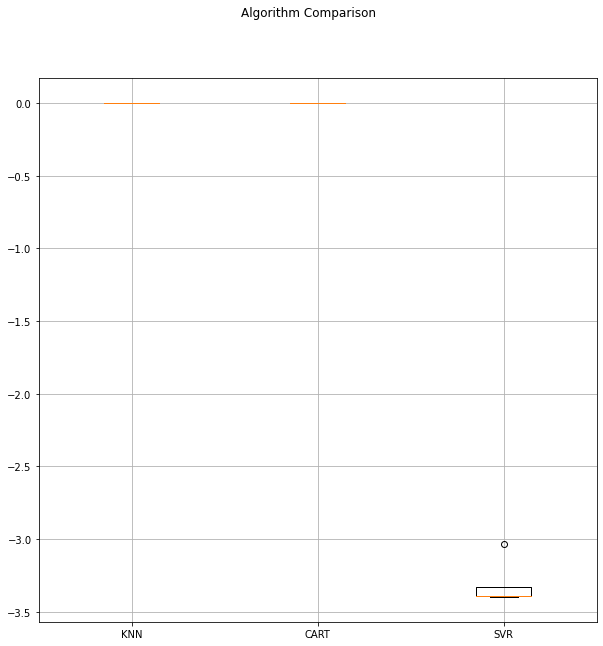

In [28]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

Baseline model implementation best model: CART (DecisionTreeRegressor)

SVR the worst result. 

## Plot-check predictions of baseline



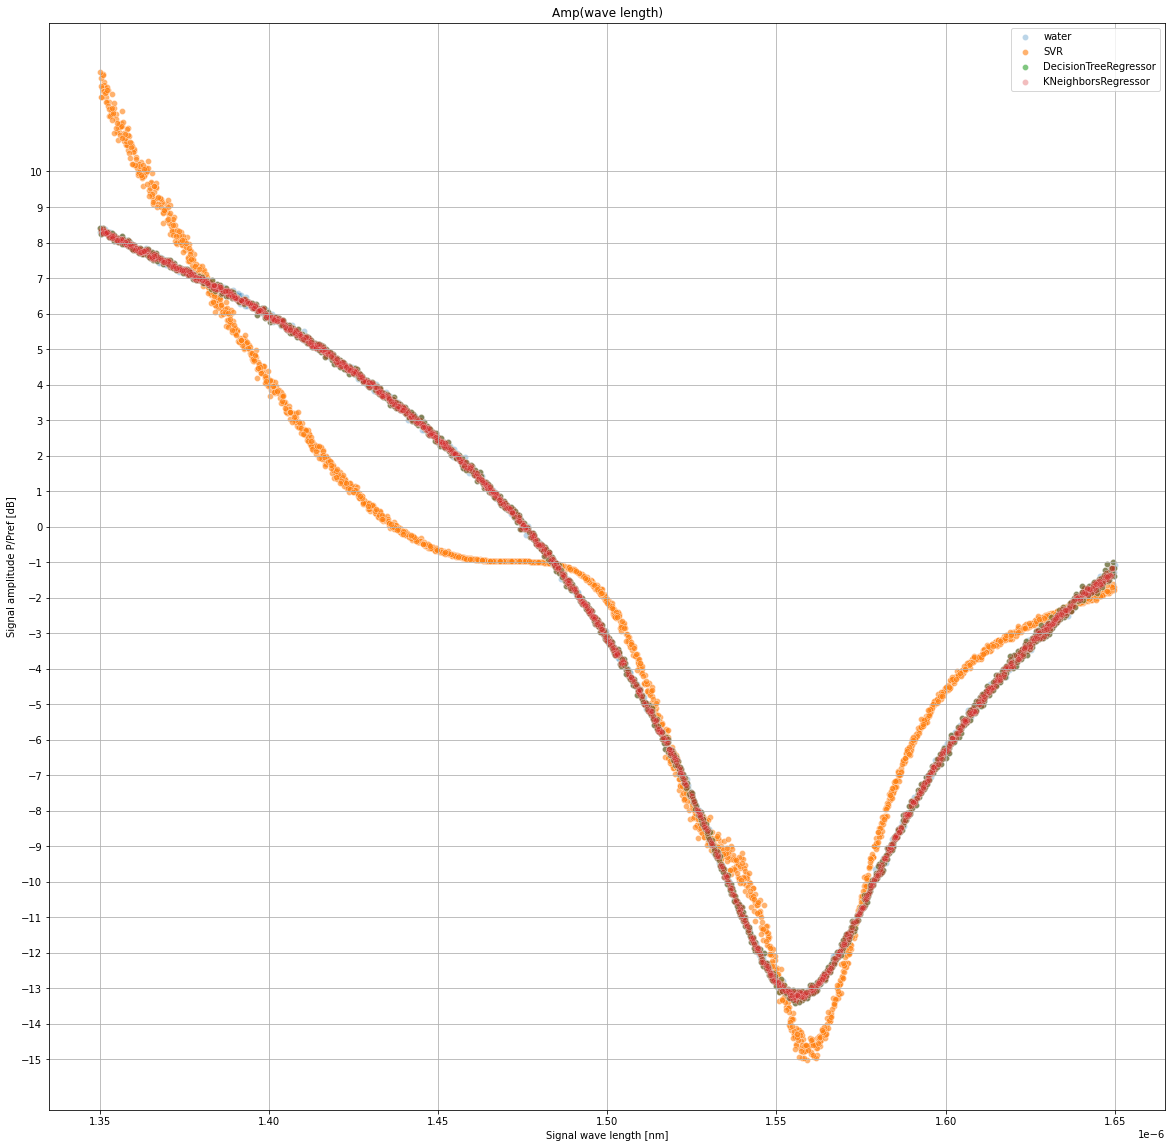

In [29]:
fig, ax = plt.subplots(figsize=(20, 20))
# sns.scatterplot(data=air, x='wave_length', y='mean_air', label='air')
# sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol')
sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water', alpha=0.3)
sns.scatterplot(data=X_train_water_air, x='wave_length', y=SVR(kernel='poly').fit(X_train_water_air,y_train_water_air).predict(X_train_water_air), label='SVR', alpha=0.6)
sns.scatterplot(data=X_train_water_air, x='wave_length', y=DecisionTreeRegressor().fit(X_train_water_air,y_train_water_air).predict(X_train_water_air), label='DecisionTreeRegressor', alpha=0.6)
sns.scatterplot(data=X_train_water_air, x='wave_length', y=KNeighborsRegressor(n_neighbors=1).fit(X_train_water_air,y_train_water_air).predict(X_train_water_air), label='KNeighborsRegressor',alpha=0.3)
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Amp(wave length)")
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

## Evaluate Algorithm: PolynomialFeatures

In [30]:
poly = PolynomialFeatures(degree=2)
model_poly = LinearRegression()

X_train_poly = poly.fit_transform(X_train_water_air)
X_test_poly = poly.transform(X_test_water_air)

model_poly.fit(X_train_poly, y_train_water_air)

poly_pred_train = model_poly.predict(X_train_poly)
poly_pred_test = model_poly.predict(X_test_poly)

In [31]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    # mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print("explained_variance: ", round(explained_variance, 4))
    # print("mean_squared_log_error: ", round(mean_squared_log_error, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))

In [32]:
print('Train result')
regression_results(y_train_water_air, poly_pred_train)

Train result
explained_variance:  1.0
r2:  1.0
MAE:  0.0
MSE:  0.0
RMSE:  0.0


In [33]:
print('Test result')
regression_results(y_test_water_air, poly_pred_test)

Test result
explained_variance:  1.0
r2:  1.0
MAE:  0.0
MSE:  0.0
RMSE:  0.0


Metric r2 equal 1 and errors  values 0 are not correct - probably overfitting, or at least very not probable - case for further investigation. 

Polynomial, in this case, is rejected.

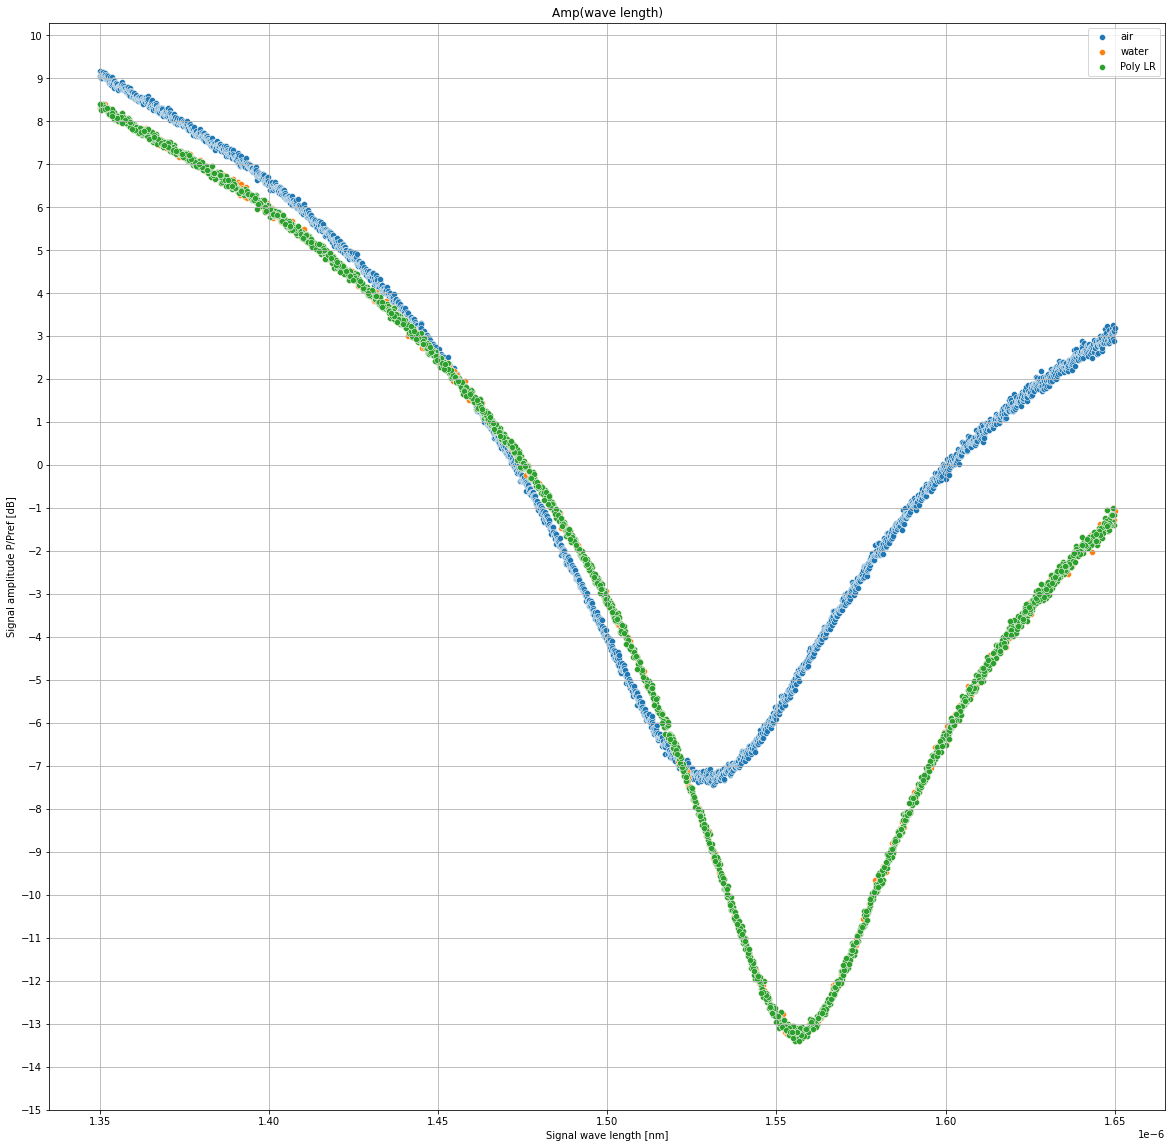

In [34]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.scatterplot(data=air, x='wave_length', y='mean_air', label='air')
# sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol')
sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water')
sns.scatterplot(data=X_train_water_air, x='wave_length', y=poly_pred_train, label='Poly LR')
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Amp(wave length)")
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

## Evaluate Algorithms: Normalization

In [35]:
# Normalization the dataset
pipelines = []
pipelines.append(('NormalizedKNN', Pipeline([('Normalized', MinMaxScaler()),('KNN', KNeighborsRegressor(n_neighbors=1))])))
pipelines.append(('NormalizedCART', Pipeline([('Normalized', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('NormalizedSVR', Pipeline([('Normalized', MinMaxScaler()),('SVR', SVR(kernel='poly'))])))
results = []
names = []
for name, model in pipelines:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_water_air, y_train_water_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

NormalizedKNN: -0.001189 (0.000121)
NormalizedCART: -0.000302 (0.000057)
NormalizedSVR: -0.030163 (0.003453)


## Evaluate Algorithms: Standardization

In [36]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor(n_neighbors=1))])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR(kernel='poly'))])))
results = []
names = []
for name, model in pipelines:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_water_air, y_train_water_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledKNN: -0.001219 (0.000125)
ScaledCART: -0.000303 (0.000038)
ScaledSVR: -0.201012 (0.017064)


Suspiciously low (almost 0) error for KNN and CART.
This is probably ralated with not proper parameters of models.

SVR improved!

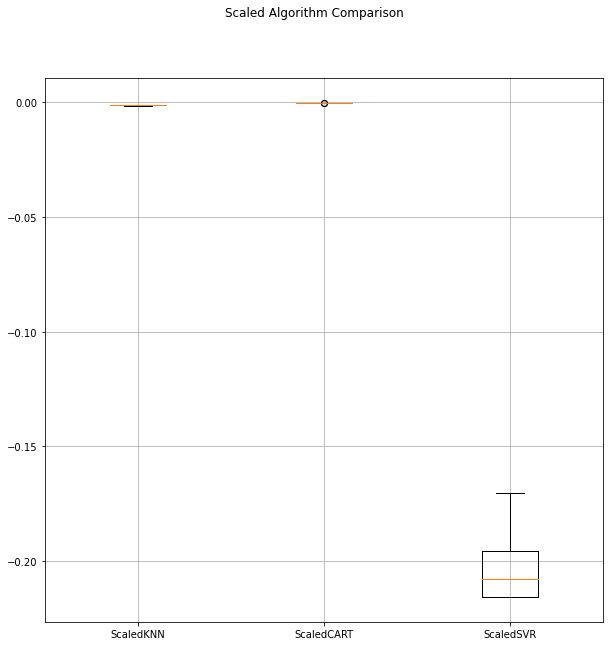

In [37]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

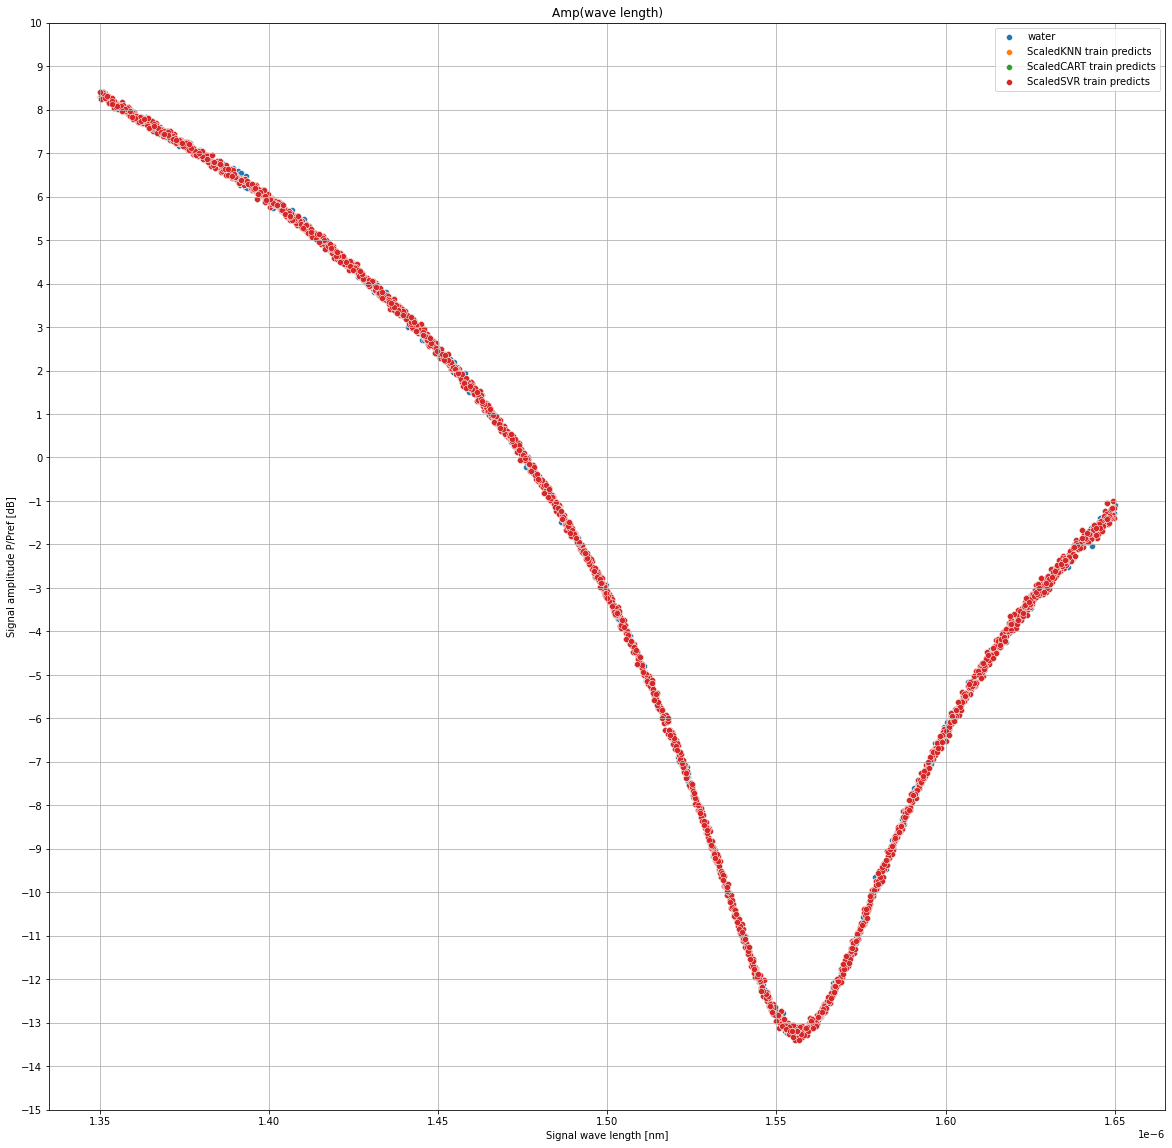

In [38]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Amp(wave length)")
# sns.scatterplot(data=air, x='wave_length', y='mean_air', label='air')
# sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol')
sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water')
for name, elem in pipelines:
  sns.scatterplot(data=X_train_water_air, x='wave_length', y=pipelines[0][1].fit(X_train_water_air,y_train_water_air).predict(X_train_water_air), label= name+ ' train predicts')
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

At this stage KNN, CART are suspicioucly good - check parameters.

## Ensemble Methods

In [39]:
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))

results = []
names = []
for name, model in ensembles:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_water_air, y_train_water_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledAB: -0.220344 (0.075706)
ScaledGBM: -0.002166 (0.000134)
ScaledRF: -0.000149 (0.000023)
ScaledET: -0.000070 (0.000014)


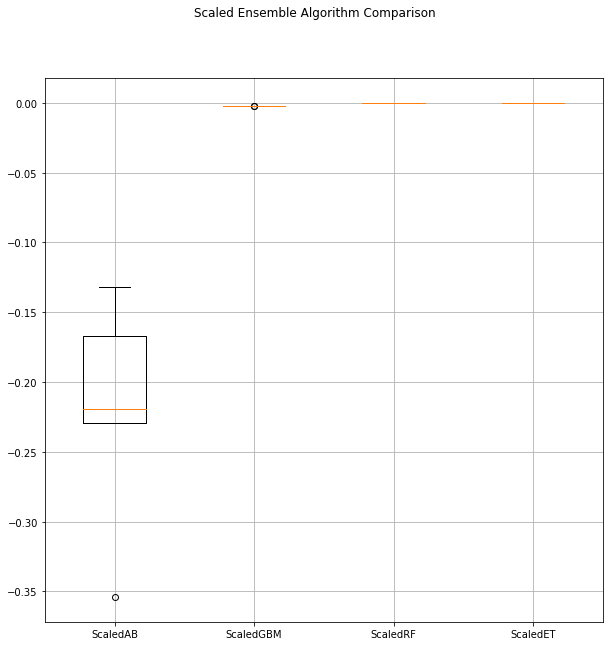

In [40]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

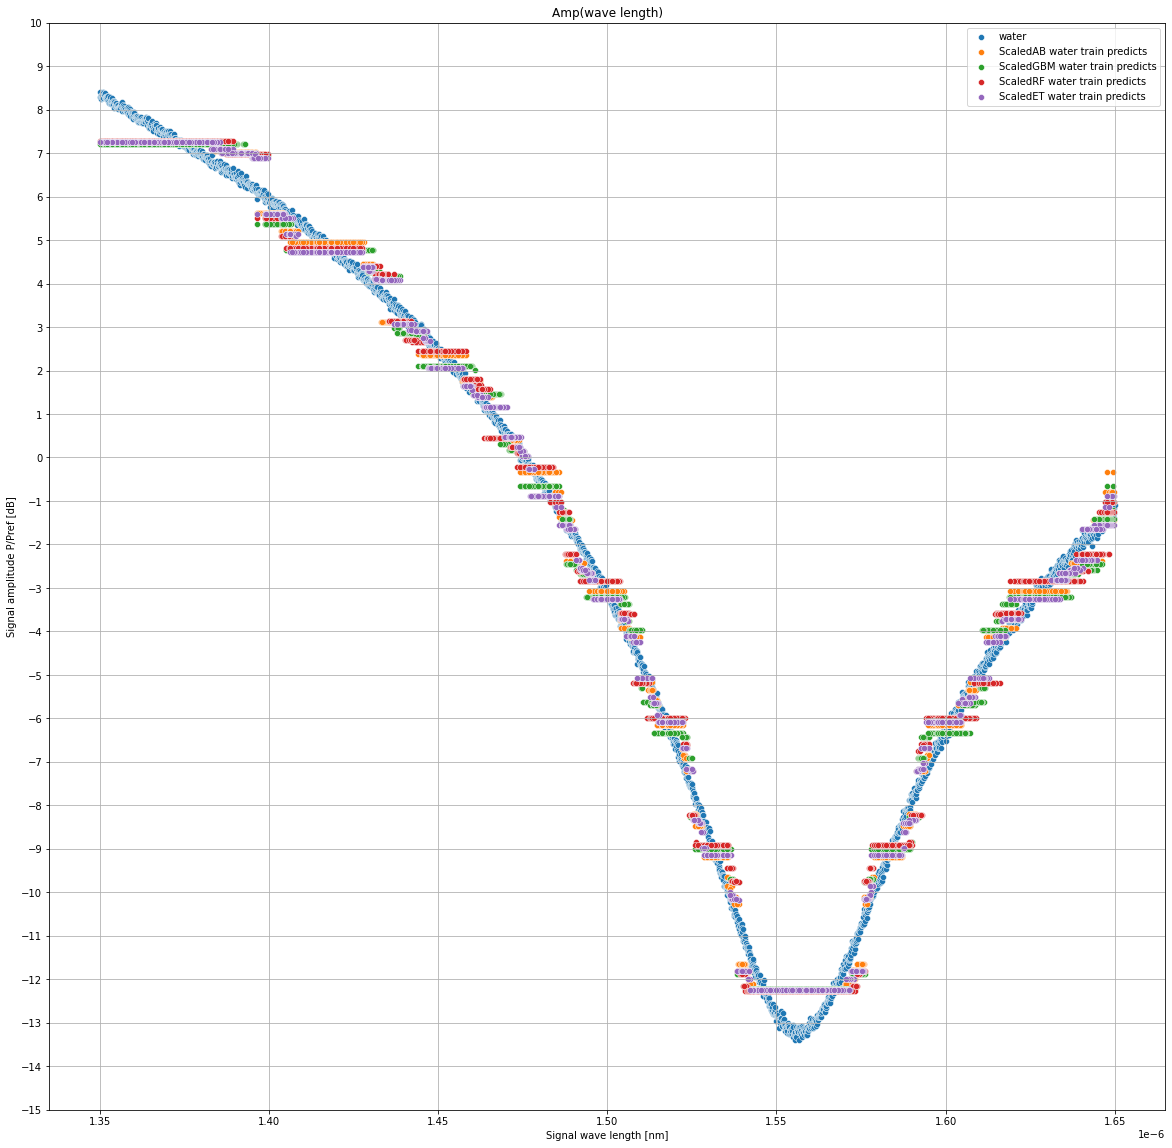

In [63]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Amp(wave length)")
# sns.scatterplot(data=air, x='wave_length', y='mean_air', label='air')
# sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol')
sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water')
for name, model in ensembles:
  sns.scatterplot(data=X_train_water_air, x='wave_length', y=ensembles[0][1].fit(X_train_water_air,y_train_water_air).predict(X_train_water_air), label= name+ ' water train predicts')
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

## Finalize Model

Chose SVR for final model

In [42]:
scaler = StandardScaler().fit(X_train_water_air)
# transform the train and test dataset
rescaledX_train = scaler.transform(X_train_water_air)
rescaledX_test = scaler.transform(X_test_water_air)

# model
model_final = SVR(kernel='poly')
model_final.fit(rescaledX_train, y_train_water_air)

# predictions on train and test
train_pred = model_final.predict(rescaledX_train)
test_pred = model_final.predict(rescaledX_test)

# prediction metrics
print('TRAIN metrics')
regression_results(y_train_water_air, train_pred)
print('\nTEST metrics')
regression_results(y_test_water_air, test_pred)

TRAIN metrics
explained_variance:  0.996
r2:  0.9959
MAE:  0.3112
MSE:  0.173
RMSE:  0.416

TEST metrics
explained_variance:  0.9963
r2:  0.9962
MAE:  0.3107
MSE:  0.1642
RMSE:  0.4052


## Summary

* Final model has very high metrics - above.
* Value from train and test sets and similar which means that model is stable
* Chosen approach with mean values looks correct
* Because of different scales of features, normalization is not enough, Standardization is correct approach 
* Standardization gives very small improvement in metrics
* It will be good to compare taken apporach (with mean values) with model trained on all 10 sensors as x-features
* Ensemble methods gives suspiciously small error - case for further investigation



# Model build for Isopropanol based on air

##  Dataset split for Isopropanol based on air

In [43]:
# Split-out validation dataset
df_iso = mean_results.copy()
X_iso_air = df_iso.drop(['mean_water'], axis=1) # features
y_iso_air = df_iso.pop('mean_iso') # target

X_train_iso_air, X_test_iso_air, y_train_iso_air, y_test_iso_air = train_test_split(X_iso_air, y_iso_air, test_size=0.20, random_state=42)

print("X_train_iso_air dimension = ", X_train_iso_air.shape)
print("X_test_iso_air dimension = ", X_test_iso_air.shape)
print("y_train_iso_air dimension = ", y_train_iso_air.shape)
print("y_train_iso_air dimension = ", y_test_iso_air.shape)
X_train_iso_air.reset_index(inplace=True, drop=True)
X_test_iso_air.reset_index(inplace=True, drop=True)
y_train_iso_air.reset_index(inplace=True, drop=True)
y_test_iso_air.reset_index(inplace=True, drop=True)

X_train_iso_air dimension =  (2400, 3)
X_test_iso_air dimension =  (601, 3)
y_train_iso_air dimension =  (2400,)
y_train_iso_air dimension =  (601,)


In [44]:
# X_iso_air
# y_iso_air

## Evaluate Algorithms: Baseline

In [45]:
# Test options and evaluation metric
# num_folds = 10
# seed = 42
# scoring = 'neg_mean_squared_error'

In [46]:
# Spot-Check Algorithms
models = []
models.append(('KNN', KNeighborsRegressor(n_neighbors=1)))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR(kernel='poly')))

Specified parameter n_neighbors=1 for KNN and kernel='poly' SVM. This is because of checking results on plot - issue described in 'Model build for Water based on air' section

In [47]:
# evaluate each model in turn
results = []
names = []
scoring = 'neg_mean_squared_error'
for name, model in models:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_iso_air, y_train_iso_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

KNN: -0.000741 (0.000101)
CART: -0.000266 (0.000033)
SVR: -4.361514 (0.183287)


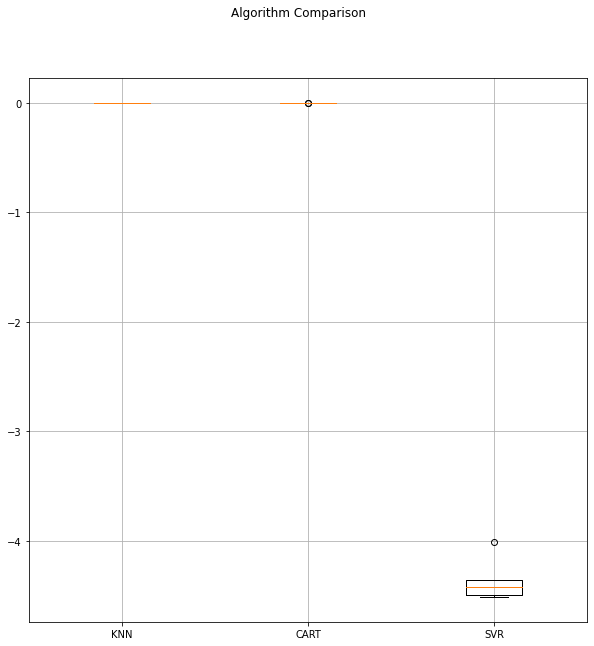

In [48]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

Baseline model implementation shows KNN and CART to have error almost equal 0. This is case for further investigation. 

Taken SVR as proper algorithm with error little above -4.

## Plot-check predictions of baseline

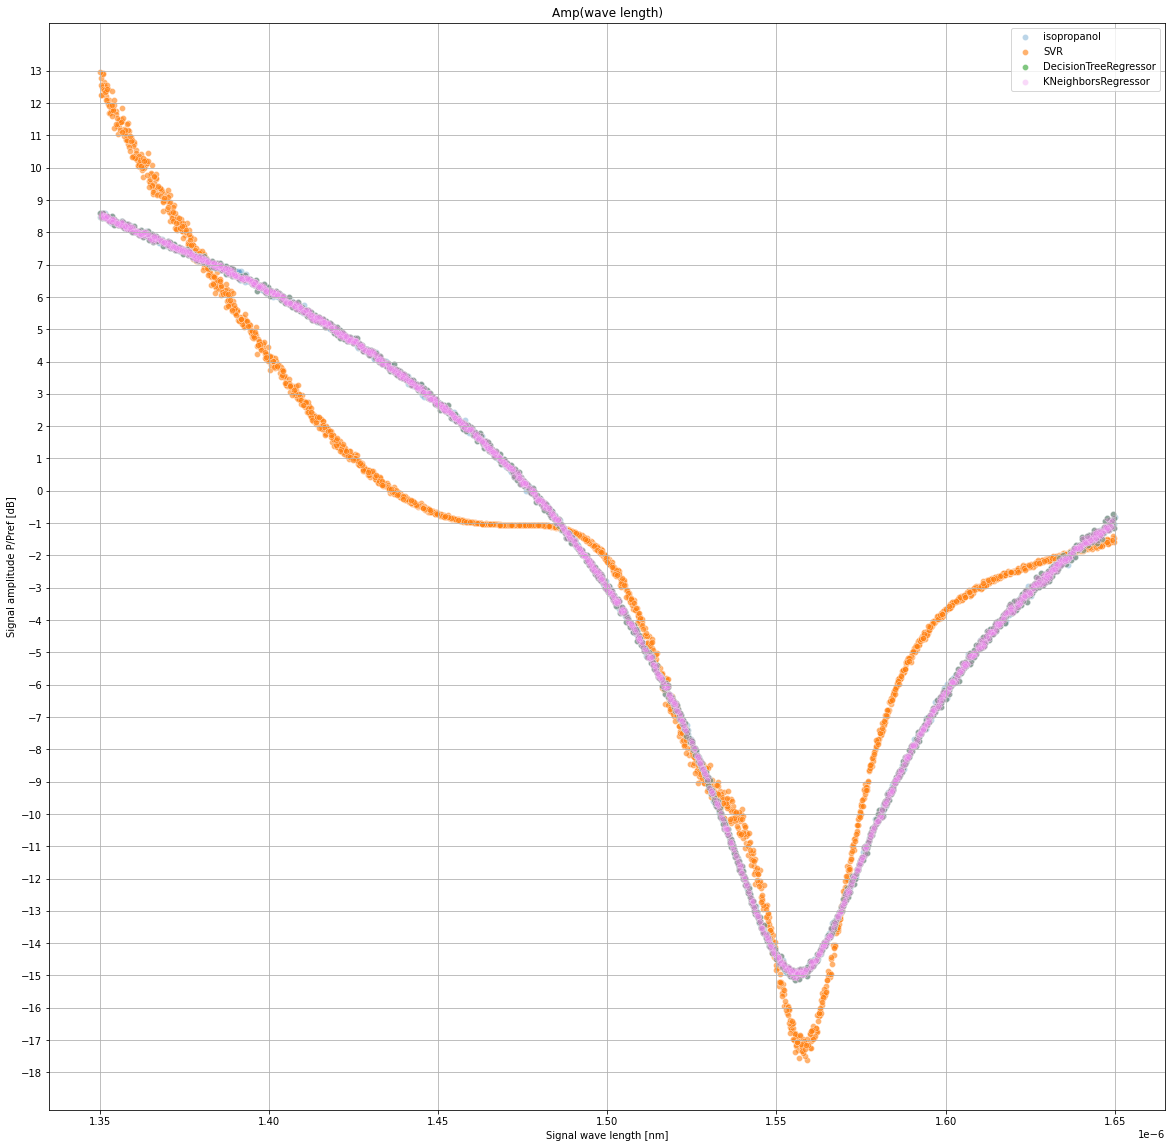

In [64]:
fig, ax = plt.subplots(figsize=(20, 20))
# sns.scatterplot(data=air, x='wave_length', y='mean_air', label='air')
sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol', alpha=0.3)
# sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water', alpha=0.3)
sns.scatterplot(data=X_train_iso_air, x='wave_length', y=SVR(kernel='poly').fit(X_train_iso_air,y_train_iso_air).predict(X_train_iso_air), label='SVR', alpha=0.6)
sns.scatterplot(data=X_train_iso_air, x='wave_length', y=DecisionTreeRegressor().fit(X_train_iso_air,y_train_iso_air).predict(X_train_iso_air), label='DecisionTreeRegressor', alpha=0.6)
sns.scatterplot(data=X_train_iso_air, x='wave_length', y=KNeighborsRegressor(n_neighbors=1).fit(X_train_iso_air,y_train_iso_air).predict(X_train_iso_air), label='KNeighborsRegressor',alpha=0.3, color='violet')
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Amp(wave length)")
plt.grid()
plt.yticks(np.arange(-18, 14, step=1))
plt.legend()

## Evaluate Algorithm: PolynomialFeatures

In [50]:
poly2 = PolynomialFeatures(degree=2)
model_poly2 = LinearRegression()

X_train_poly2 = poly2.fit_transform(X_train_iso_air)
X_test_poly2 = poly2.transform(X_test_iso_air)

model_poly2.fit(X_train_poly2, y_train_iso_air)

poly2_pred_train = model_poly2.predict(X_train_poly2)
poly2_pred_test = model_poly2.predict(X_test_poly2)

In [51]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    # mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print("explained_variance: ", round(explained_variance, 4))
    # print("mean_squared_log_error: ", round(mean_squared_log_error, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))

In [52]:
print('Train result')
regression_results(y_train_iso_air, poly2_pred_train)

Train result
explained_variance:  1.0
r2:  1.0
MAE:  0.0
MSE:  0.0
RMSE:  0.0


In [53]:
print('Test result')
regression_results(y_test_iso_air, poly2_pred_test)

Test result
explained_variance:  1.0
r2:  1.0
MAE:  0.0
MSE:  0.0
RMSE:  0.0


Metric r2 equal 1 and errors  values 0 are not correct - probably overfitting, or at least very not probable - case for further investigation. 

Polynomial, in this case, is rejected.

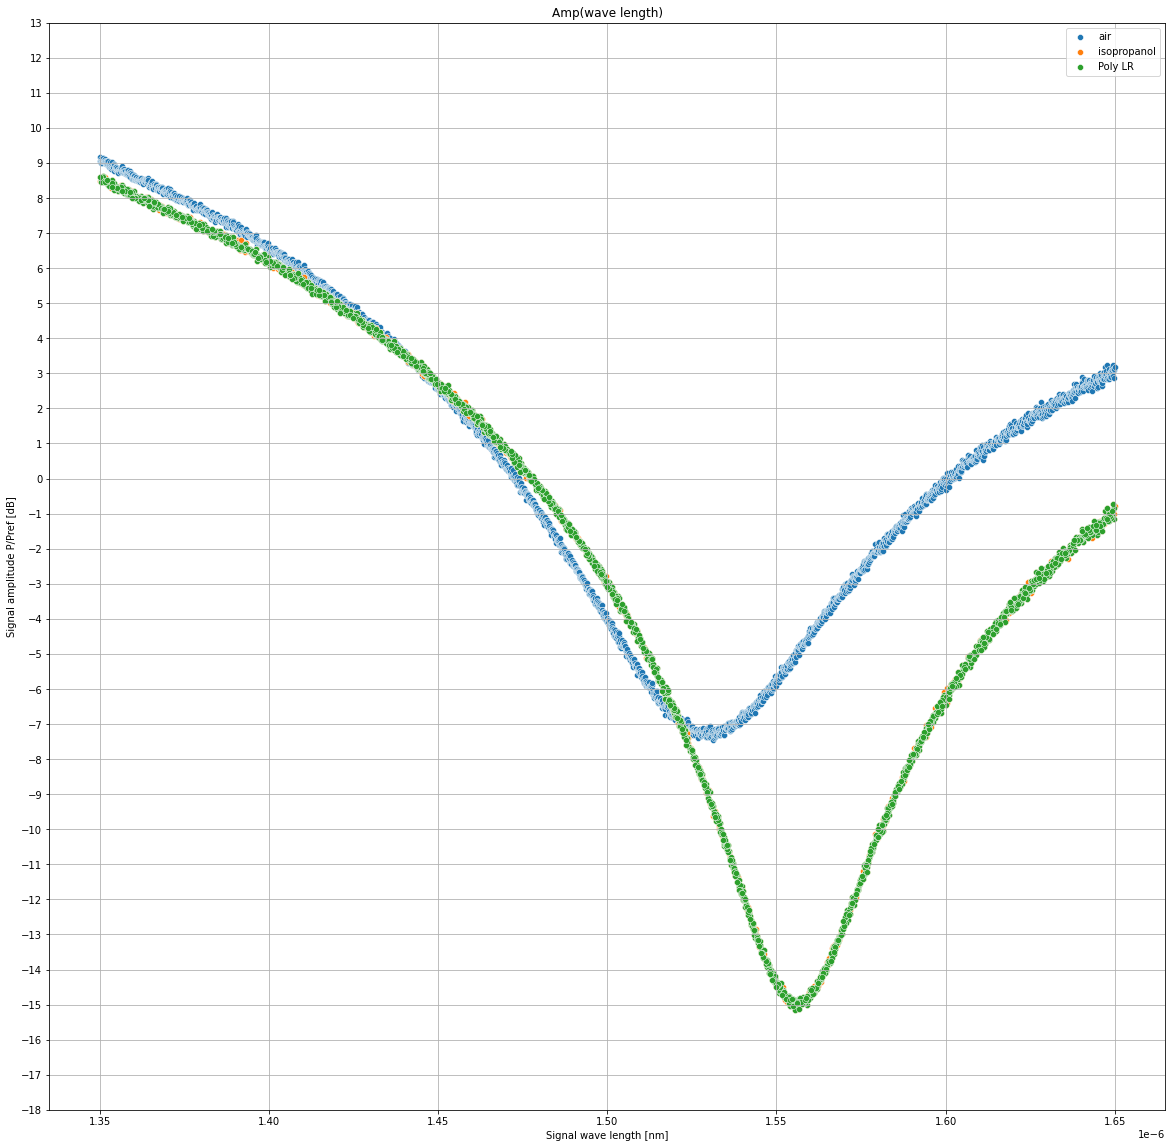

In [54]:
|fig, ax = plt.subplots(figsize=(20, 20))
sns.scatterplot(data=air, x='wave_length', y='mean_air', label='air')
sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol')
# sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water')

sns.scatterplot(data=X_train_iso_air, x='wave_length', y=poly2_pred_train, label='Poly LR')
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Amp(wave length)")
plt.grid()
plt.yticks(np.arange(-18, 14, step=1))
plt.legend()

## Evaluate Algorithms: Normalization

In [55]:
# Normalization the dataset
pipelines = []
pipelines.append(('NormalizedKNN', Pipeline([('Normalized', MinMaxScaler()),('KNN', KNeighborsRegressor(n_neighbors=1))])))
pipelines.append(('NormalizedCART', Pipeline([('Normalized', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('NormalizedSVR', Pipeline([('Normalized', MinMaxScaler()),('SVR', SVR(kernel='poly'))])))
results = []
names = []
for name, model in pipelines:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_iso_air, y_train_iso_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

NormalizedKNN: -0.001398 (0.000168)
NormalizedCART: -0.000379 (0.000040)
NormalizedSVR: -0.046471 (0.005100)


## Evaluate Algorithms: Standardization

In [56]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor(n_neighbors=1))])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR(kernel='poly'))])))
results = []
names = []
for name, model in pipelines:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_iso_air, y_train_iso_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledKNN: -0.001403 (0.000161)
ScaledCART: -0.000524 (0.000243)
ScaledSVR: -0.169282 (0.014074)


Suspiciously low (almost 0) error for:

* ScaledKNN: -0.003595 (0.000568)
* ScaledCART: -0.003880 (0.000402)

This is probably ralated with not proper parameters of models.

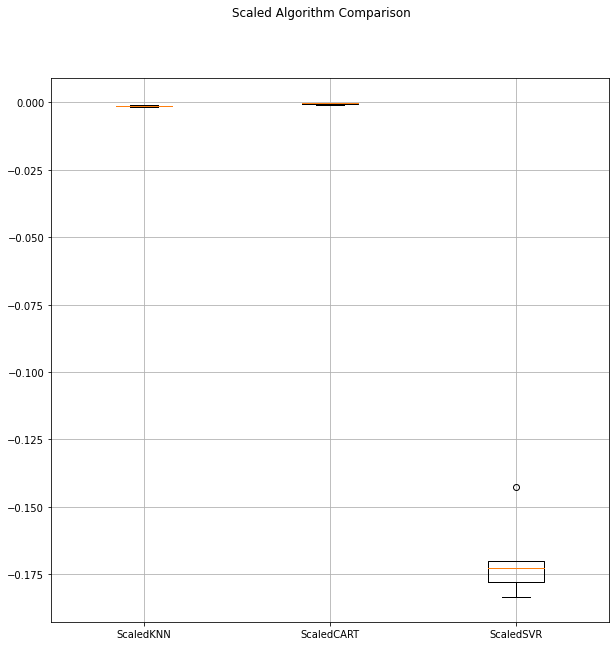

In [57]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.grid()
ax.set_xticklabels(names)
plt.show()

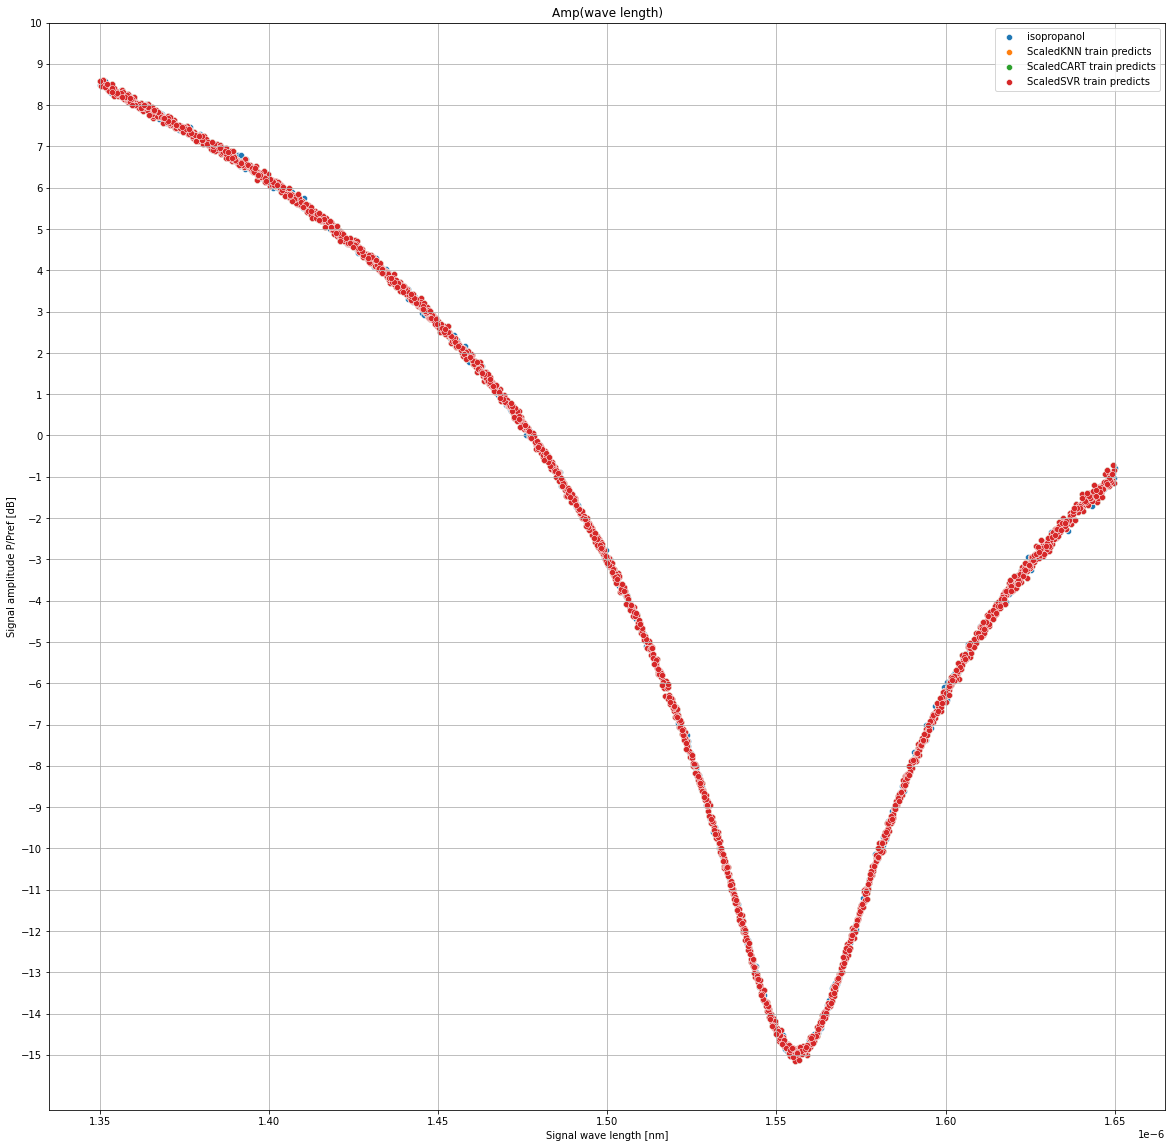

In [58]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Amp(wave length)")
# sns.scatterplot(data=air, x='wave_length', y='mean_air', label='air')
sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol')
# sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water')
for name, elem in pipelines:
  sns.scatterplot(data=X_train_iso_air, x='wave_length', y=pipelines[0][1].fit(X_train_iso_air,y_train_iso_air).predict(X_train_iso_air), label= name+ ' train predicts')
plt.grid()
plt.yticks(np.arange(-15, 11, step=1))
plt.legend()

## Ensemble Methods

In [59]:
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))

results = []
names = []
for name, model in ensembles:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train_iso_air, y_train_iso_air, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledAB: -0.211446 (0.041019)
ScaledGBM: -0.002658 (0.000243)
ScaledRF: -0.000238 (0.000119)
ScaledET: -0.000088 (0.000013)


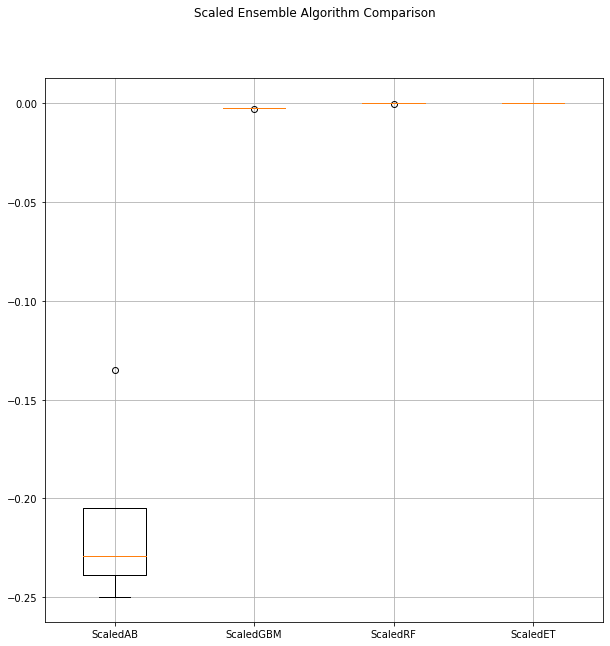

In [60]:
# Compare Algorithms
fig = plt.figure(figsize=(10,10))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.grid()
plt.show()

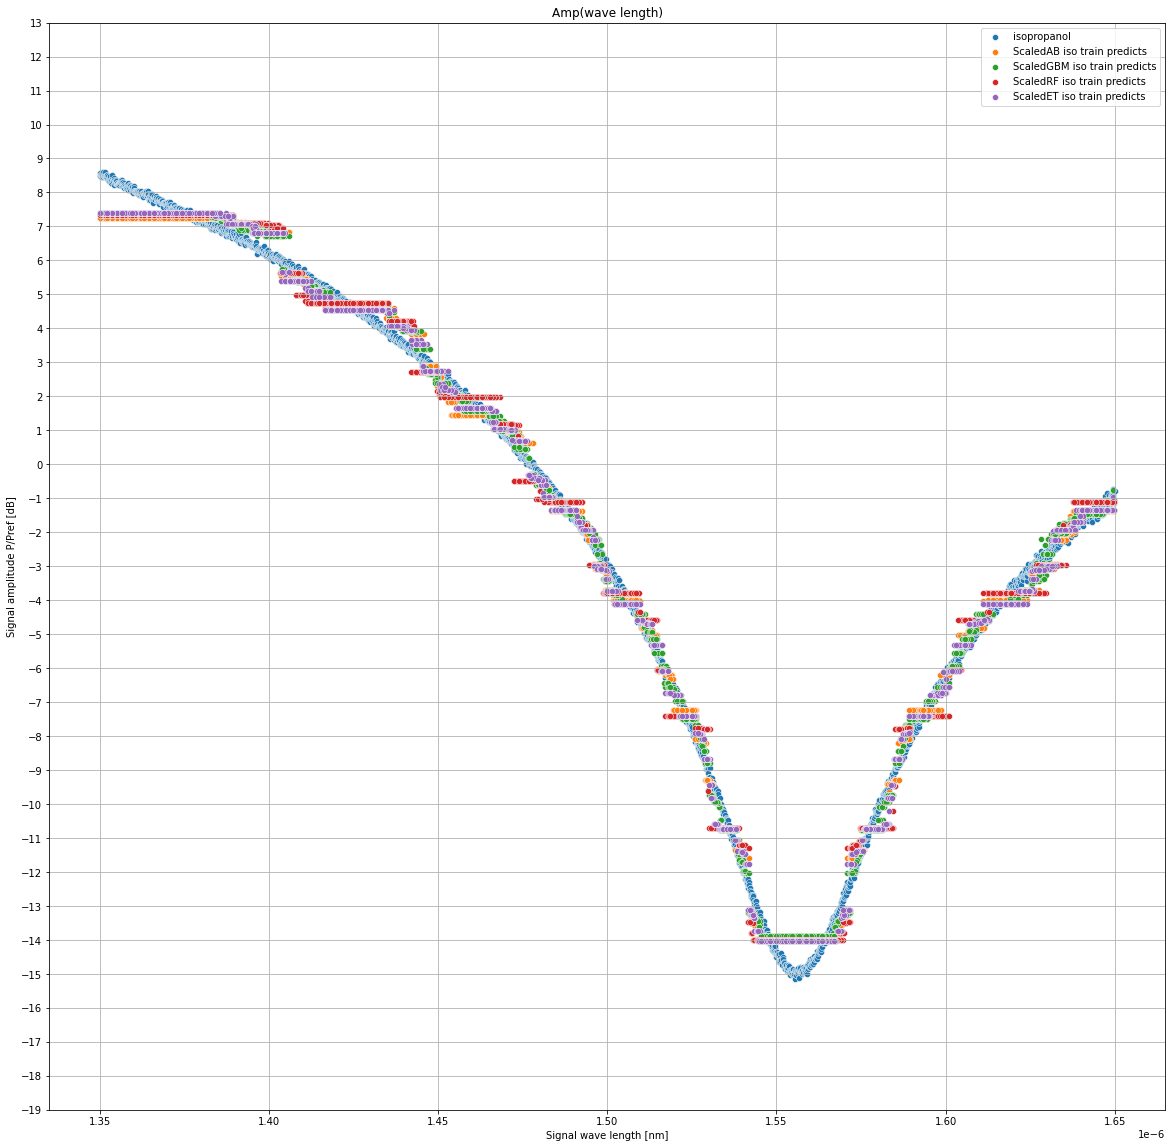

In [61]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.xlabel("Signal wave length [nm]")
plt.ylabel("Signal amplitude P/Pref [dB]")
plt.title("Amp(wave length)")
# sns.scatterplot(data=air, x='wave_length', y='mean_air', label='air')
sns.scatterplot(data=iso, x='wave_length', y='mean_iso', label='isopropanol')
# sns.scatterplot(data=water, x='wave_length', y='mean_water', label='water')
for name, model in ensembles:
  sns.scatterplot(data=X_train_iso_air, x='wave_length', y=ensembles[0][1].fit(X_train_iso_air,y_train_iso_air).predict(X_train_iso_air), label= name+ ' iso train predicts')
plt.grid()
plt.yticks(np.arange(-19, 14, step=1))
plt.legend()

## Finalize Model

In [62]:
scaler = StandardScaler().fit(X_train_iso_air)
# transform the train and test dataset
rescaledX_train = scaler.transform(X_train_iso_air)
rescaledX_test = scaler.transform(X_test_iso_air)

# model
model_final = SVR(kernel='poly')
model_final.fit(rescaledX_train, y_train_iso_air)

# predictions on train and test
train_pred = model_final.predict(rescaledX_train)
test_pred = model_final.predict(rescaledX_test)

# prediction metrics
print('TRAIN metrics')
regression_results(y_train_iso_air, train_pred)
print('\nTEST metrics')
regression_results(y_test_iso_air, test_pred)

TRAIN metrics
explained_variance:  0.9971
r2:  0.9971
MAE:  0.2981
MSE:  0.1408
RMSE:  0.3753

TEST metrics
explained_variance:  0.9972
r2:  0.9972
MAE:  0.2948
MSE:  0.1346
RMSE:  0.3669


## Summary

* Final model has very high metrics - above.
* Value from train and test sets and similar which means that model is stable
* Chosen approach with mean values looks OK but can be too simplified approach
* Because of different scales of features, normalization is not enough, Standardization is correct approach 
* Standardization gives very small improvement in metrics


# Further analysis proposition

*   Production code should check possible outliers and replace with e.g. mean or median
*   Worth to compare taken apporach (with mean values) with model trained on all 10 sensors as x-features
* Tuning of used algorithms 
* Check algoorithms with suspicious low error.